In [39]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [40]:
labels = pd.read_csv('data/processed-labels/seattle_labels_all.csv')

In [41]:
labels

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,lat,lng,geometry
0,85055,CurbRamp,1.0,NjPAkwTxWsayAq3kCugvdA,1,107.750000,-15.62500,270.556610,0.907036,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618599,-122.332787,POINT (-122.3327865600586 47.61859893798828)
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.87500,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617805,-122.331886,POINT (-122.3318862915039 47.61780548095703)
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617512,-122.331833,POINT (-122.33183288574219 47.61751174926758)
3,85060,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617519,-122.331879,POINT (-122.33187866210938 47.61751937866211)
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.00000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617638,-122.332047,POINT (-122.33204650878906 47.617637634277344)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195538,231270,CurbRamp,1.0,R-sTl5O6sOdVPurgTWy3EQ,1,332.468750,-35.00000,215.130295,-0.157570,155af0a9-4149-4436-8aa3-7573e160036d,47.540771,-122.267258,POINT (-122.26725769042969 47.540771484375)
195539,231285,NoSidewalk,5.0,N5MrAAtHZO2JGXUrYAYnSQ,3,0.890625,-11.65625,179.161057,-5.825714,155af0a9-4149-4436-8aa3-7573e160036d,47.552292,-122.263443,POINT (-122.26344299316406 47.55229187011719)
195540,231338,CurbRamp,1.0,d3oBrJ-nDtKMwlE7svc6pg,1,253.562500,-35.00000,177.959915,-0.962440,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563271,-122.281792,POINT (-122.28179168701172 47.563270568847656)
195541,231339,CurbRamp,1.0,AOIBJ12BjFanDJF1Ark05Q,1,110.312500,-35.00000,179.365723,-1.093400,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563469,-122.281654,POINT (-122.28165435791016 47.56346893310547)


In [42]:
#read in all files in the feature folder
clustered = pd.read_csv('data/features/clustered.csv')
fp = pd.read_csv('data/features/false_positives_2.csv')
distance = pd.read_csv('data/features/distance.csv')
intersection_distance = pd.read_csv('data/features/intersection_distance.csv')
optional_input = pd.read_csv('data/features/optional_input.csv')

In [43]:
#change column name distance to intersection distance
intersection_distance = intersection_distance.rename(columns={'distance': 'intersection_distance'})
#change nan to -1
intersection_distance = intersection_distance.fillna(-1)
intersection_distance


,label_id,way_type,intersection_distance
0,9,tertiary,40.679454
1,10,tertiary,36.863199
2,11,-1,-1.000000
3,12,-1,-1.000000
4,13,-1,-1.000000
...,...,...,...
195538,233233,-1,-1.000000
195539,233234,-1,-1.000000
195540,233235,-1,-1.000000
195541,233236,tertiary,53.975477


In [44]:
#merge all into one on label_id
df = pd.merge(labels, clustered, on='label_id')
df = pd.merge(df, fp, on='label_id')
df = pd.merge(df, distance, on='label_id')
df = pd.merge(df, optional_input, on='label_id', how='inner')
df = pd.merge(df, intersection_distance, on='label_id', how='inner')

In [45]:
df

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,lat,lng,geometry,clustered,count,false_positive,distance,tag_list,description,tag_count,way_type,intersection_distance
0,85055,CurbRamp,1.0,NjPAkwTxWsayAq3kCugvdA,1,107.750000,-15.62500,270.556610,0.907036,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618599,-122.332787,POINT (-122.3327865600586 47.61859893798828),0.0,1.0,0,5.435411,0.0,0.0,0.0,residential,59.130699
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.87500,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617805,-122.331886,POINT (-122.3318862915039 47.61780548095703),0.0,7.0,0,12.187807,0.0,1.0,0.0,-1,-1.000000
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617512,-122.331833,POINT (-122.33183288574219 47.61751174926758),1.0,6.0,0,1.261442,0.0,0.0,0.0,tertiary,37.121175
3,85060,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617519,-122.331879,POINT (-122.33187866210938 47.61751937866211),0.0,4.0,0,0.859638,0.0,0.0,0.0,tertiary,33.832501
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.00000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617638,-122.332047,POINT (-122.33204650878906 47.617637634277344),0.0,6.0,0,2.443982,0.0,0.0,0.0,tertiary,46.324623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195538,231270,CurbRamp,1.0,R-sTl5O6sOdVPurgTWy3EQ,1,332.468750,-35.00000,215.130295,-0.157570,155af0a9-4149-4436-8aa3-7573e160036d,47.540771,-122.267258,POINT (-122.26725769042969 47.540771484375),1.0,10.0,0,19.281464,0.0,0.0,0.0,residential,33.457578
195539,231285,NoSidewalk,5.0,N5MrAAtHZO2JGXUrYAYnSQ,3,0.890625,-11.65625,179.161057,-5.825714,155af0a9-4149-4436-8aa3-7573e160036d,47.552292,-122.263443,POINT (-122.26344299316406 47.55229187011719),1.0,12.0,0,7.199212,0.0,0.0,0.0,-1,-1.000000
195540,231338,CurbRamp,1.0,d3oBrJ-nDtKMwlE7svc6pg,1,253.562500,-35.00000,177.959915,-0.962440,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563271,-122.281792,POINT (-122.28179168701172 47.563270568847656),0.0,9.0,1,14.445776,0.0,0.0,0.0,residential,152.820404
195541,231339,CurbRamp,1.0,AOIBJ12BjFanDJF1Ark05Q,1,110.312500,-35.00000,179.365723,-1.093400,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563469,-122.281654,POINT (-122.28165435791016 47.56346893310547),0.0,9.0,1,20.171446,0.0,0.0,0.0,residential,225.060263


In [46]:
gt = pd.read_csv('data/features/seattle_ground_truth_labels.csv')

In [47]:
gt

,label_id,ground_truth
0,9,1
1,12,1
2,20,1
3,22,1
4,23,1
...,...,...
16575,233166,0
16576,233167,1
16577,233171,1
16578,233172,1


In [48]:
#merge gt with labels how left
test= pd.merge(df, gt, on='label_id', how='right')

In [49]:
#rename ground truth to verified
test.rename(columns={'ground_truth': 'verified'}, inplace=True)

In [50]:
#drop the geometry column and save as csv
test.drop(columns=['geometry']).to_csv('data/test_set_seattle.csv', index=False)

In [51]:
test.verified.value_counts()

1    12867
0     3713
Name: verified, dtype: int64

In [52]:
test

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,lat,lng,geometry,clustered,count,false_positive,distance,tag_list,description,tag_count,way_type,intersection_distance,verified
0,9,CurbRamp,2.0,3TO1sxavsQLIliltuPh5yw,3,299.323669,-17.540178,180.368912,1.460938,e4ff325c-309b-4ea6-8555-8f973e662362,47.598358,-122.306519,POINT (-122.3065185546875 47.598358154296875),1.0,6.0,0,12.359854,1.0,0.0,1.0,tertiary,40.679454,1
1,12,SurfaceProblem,3.0,2zMHlmqFF6V2SHqueb1fZA,3,20.665178,-14.486608,89.751045,-1.658913,e4ff325c-309b-4ea6-8555-8f973e662362,47.598400,-122.306679,POINT (-122.30667877197266 47.5984001159668),0.0,3.0,0,1.758375,1.0,0.0,1.0,-1,-1.000000,1
2,20,CurbRamp,1.0,lk95zcW0edw2sZCB1rMPTA,3,341.866058,-12.957589,106.566940,-2.300713,e4ff325c-309b-4ea6-8555-8f973e662362,47.598362,-122.309052,POINT (-122.30905151367188 47.59836196899414),1.0,6.0,0,5.536850,0.0,0.0,0.0,residential,13.214736,1
3,22,CurbRamp,1.0,hYEH3dM1ydGeOvU7l906_A,3,210.609375,-13.984375,255.282394,0.888550,e4ff325c-309b-4ea6-8555-8f973e662362,47.586857,-122.304230,POINT (-122.30422973632812 47.586856842041016),1.0,4.0,0,11.320579,0.0,0.0,0.0,residential,27.025511,1
4,23,SurfaceProblem,4.0,hYEH3dM1ydGeOvU7l906_A,2,308.345978,-34.910713,255.282394,0.888550,e4ff325c-309b-4ea6-8555-8f973e662362,47.586967,-122.304184,POINT (-122.30418395996094 47.58696746826172),0.0,4.0,0,15.889878,1.0,0.0,1.0,-1,-1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16575,233166,Obstacle,4.0,hJDiPHlOoVDAS8AF4ZQ2ow,1,276.312500,-22.812500,304.674866,0.043660,dc9c7b1a-e2bd-4e7f-9d7e-dd239d7c7062,47.549702,-122.323402,POINT (-122.32340240478516 47.54970169067383),0.0,5.0,0,18.215611,1.0,0.0,2.0,-1,-1.000000,0
16576,233167,NoSidewalk,5.0,IEprRf1khSshvYgwnVkRVA,1,312.500000,-17.187500,307.725586,0.072340,dc9c7b1a-e2bd-4e7f-9d7e-dd239d7c7062,47.549858,-122.323418,POINT (-122.32341766357422 47.54985809326172),0.0,3.0,0,27.443284,0.0,0.0,0.0,-1,-1.000000,1
16577,233171,NoCurbRamp,5.0,hFVojVcV0UAWHtVa9Nnk7Q,1,155.562500,-31.437500,137.767288,-0.617290,dc9c7b1a-e2bd-4e7f-9d7e-dd239d7c7062,47.550358,-122.323029,POINT (-122.32302856445312 47.550357818603516),1.0,6.0,0,24.258974,0.0,0.0,0.0,residential,33.350587,1
16578,233172,NoCurbRamp,5.0,hFVojVcV0UAWHtVa9Nnk7Q,1,155.562500,-31.437500,137.767288,-0.617290,dc9c7b1a-e2bd-4e7f-9d7e-dd239d7c7062,47.550392,-122.322937,POINT (-122.32293701171875 47.550392150878906),1.0,6.0,0,20.184373,0.0,0.0,0.0,residential,25.462447,1


In [15]:
#in test set select verified = 1 label_type = curb_ramp
true_curb_ramp = test[(test['verified'] == 1) & (test['label_type'] == 'CurbRamp')]
false_curb_ramp = test[(test['verified'] == 0) & (test['label_type'] == 'CurbRamp')]

In [16]:
true_no_curb_ramp = test[(test['verified'] == 1) & (test['label_type'] == 'NoCurbRamp')]
false_no_curb_ramp = test[(test['verified'] == 0) & (test['label_type'] == 'NoCurbRamp')]


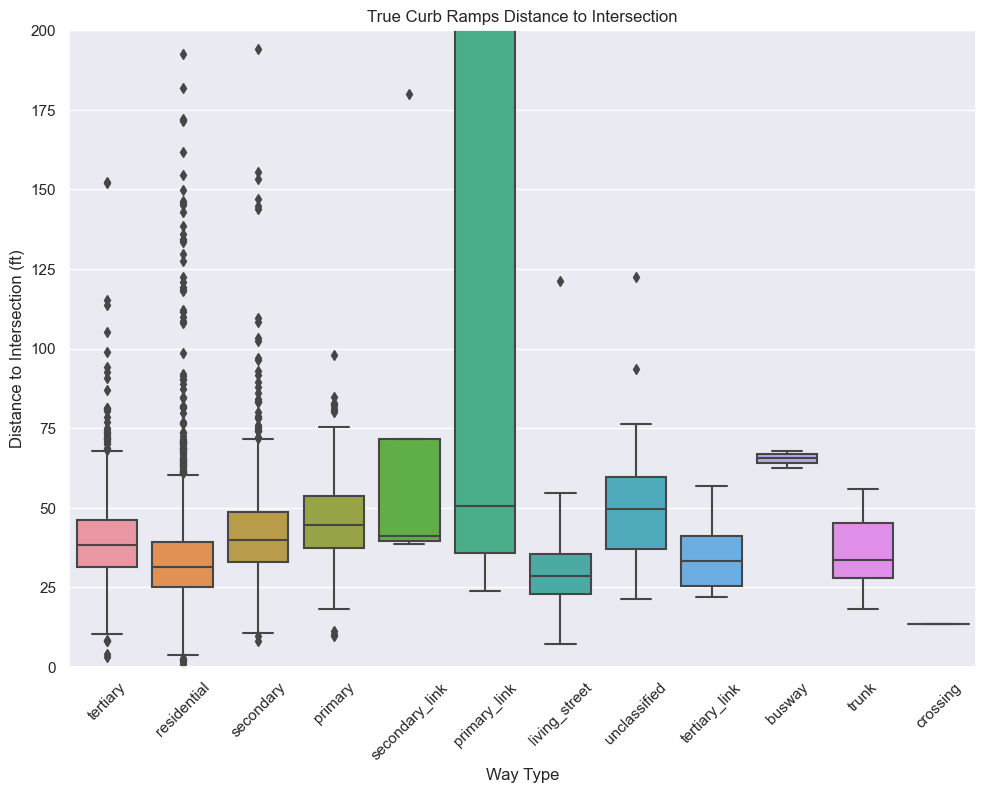

In [17]:
#plot true curb ramp way_type and intersection distance boxplot
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="way_type", y="intersection_distance", data=true_curb_ramp )
ax.set_title('True Curb Ramps Distance to Intersection')
ax.set_xlabel('Way Type')
ax.set_ylabel('Distance to Intersection (ft)')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
#zoom in on y-axis
plt.ylim(0, 200)
plt.show()


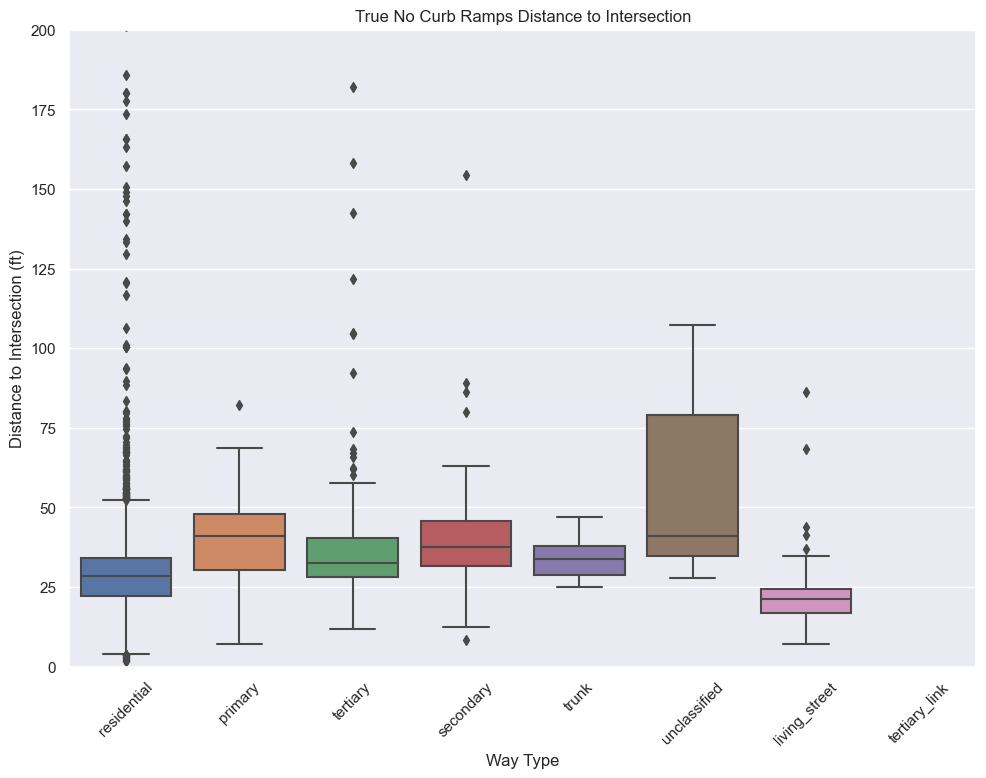

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="way_type", y="intersection_distance", data=true_no_curb_ramp )
ax.set_title('True No Curb Ramps Distance to Intersection')
ax.set_xlabel('Way Type')
ax.set_ylabel('Distance to Intersection (ft)')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
#zoom in on y-axis
plt.ylim(0, 200)
plt.show()

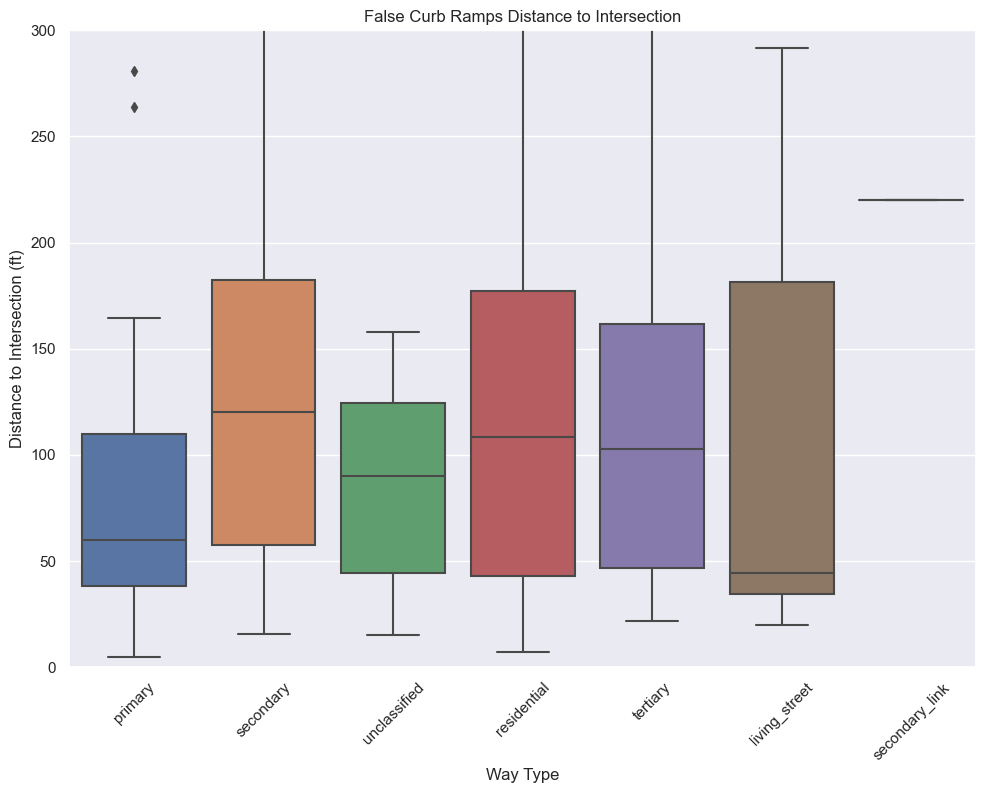

In [19]:
#plot true curb ramp way_type and intersection distance boxplot
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="way_type", y="intersection_distance", data=false_curb_ramp )
ax.set_title('False Curb Ramps Distance to Intersection')
ax.set_xlabel('Way Type')
ax.set_ylabel('Distance to Intersection (ft)')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
#zoom in on y-axis
plt.ylim(0, 300)
plt.show()

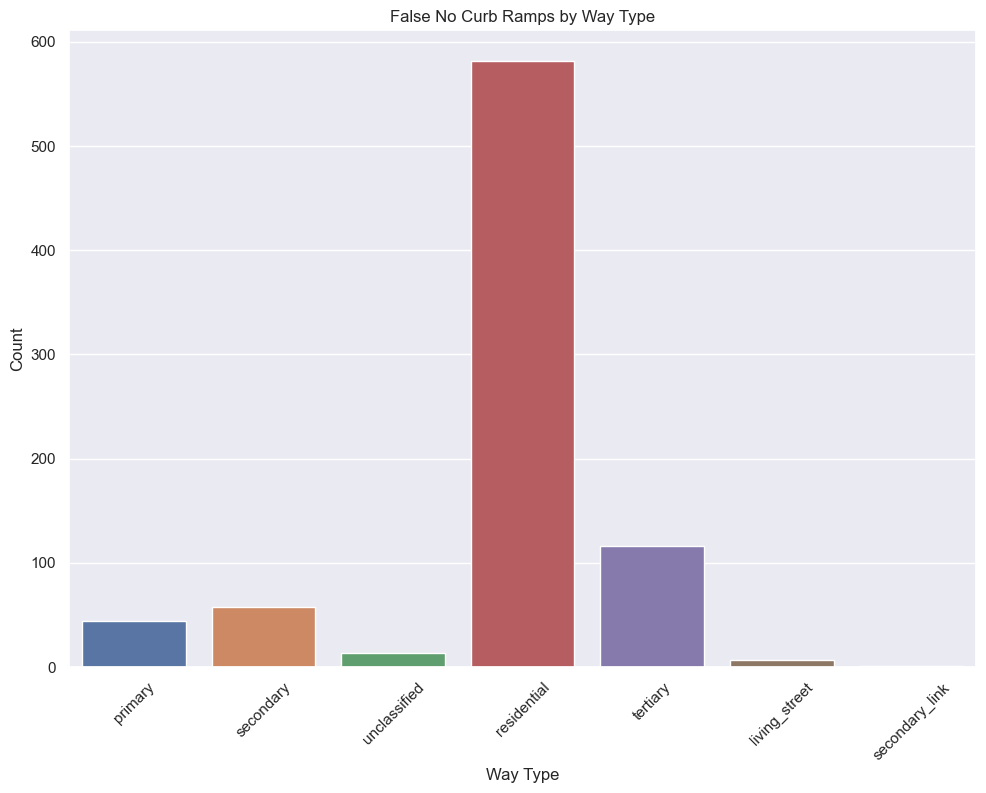

In [25]:
#false no curb ramp plot by way type barplot
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x="way_type", data=false_curb_ramp)
ax.set_title('False No Curb Ramps by Way Type')
ax.set_xlabel('Way Type')
ax.set_ylabel('Count')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()


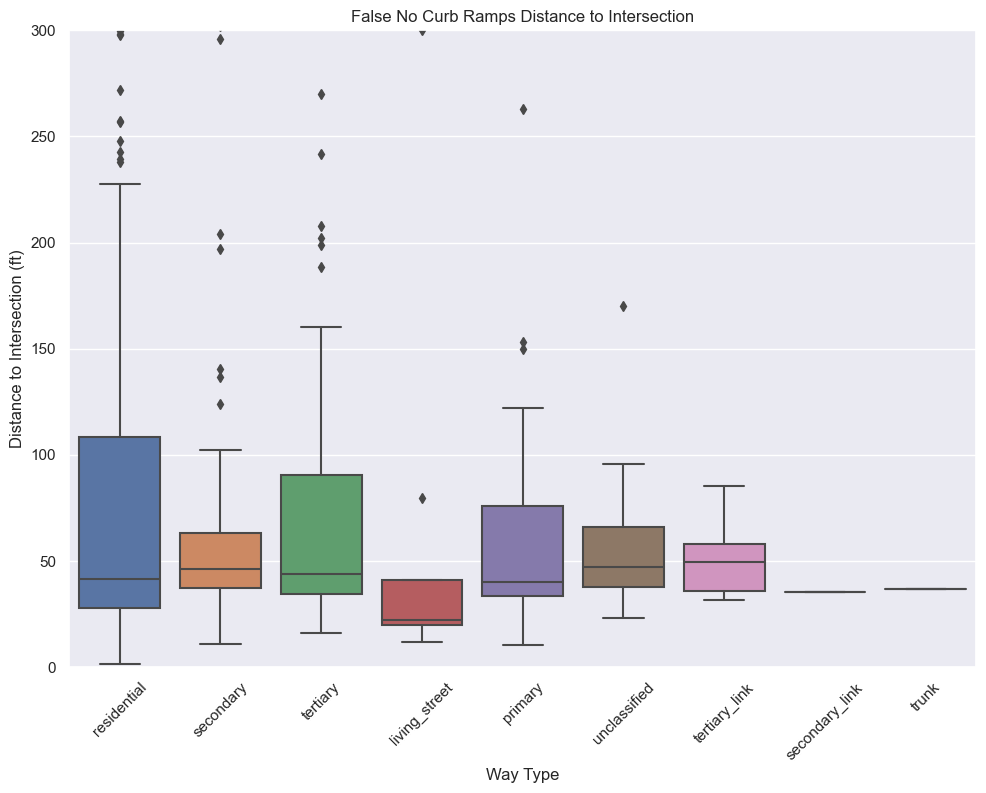

In [20]:
#plot true curb ramp way_type and intersection distance boxplot
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="way_type", y="intersection_distance", data=false_no_curb_ramp )
ax.set_title('False No Curb Ramps Distance to Intersection')
ax.set_xlabel('Way Type')
ax.set_ylabel('Distance to Intersection (ft)')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
#zoom in on y-axis
plt.ylim(0, 300)
plt.show()

In [ ]:
label_types = df['label_type'].unique().tolist()

In [ ]:
#boxplot distance by label type
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="label_type", y="distance", hue="verified", data=test, palette="mako")
#zoom in on the boxplot
plt.ylim(0, 40)
plt.xticks(range(len(label_types)), label_types, rotation=45)
plt.show()

In [53]:
#if the label_id in gt take it out of df
training = df[~df.label_id.isin(test.label_id)]

In [54]:
training

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,lat,lng,geometry,clustered,count,false_positive,distance,tag_list,description,tag_count,way_type,intersection_distance
0,85055,CurbRamp,1.0,NjPAkwTxWsayAq3kCugvdA,1,107.750000,-15.62500,270.556610,0.907036,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618599,-122.332787,POINT (-122.3327865600586 47.61859893798828),0.0,1.0,0,5.435411,0.0,0.0,0.0,residential,59.130699
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.87500,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617805,-122.331886,POINT (-122.3318862915039 47.61780548095703),0.0,7.0,0,12.187807,0.0,1.0,0.0,-1,-1.000000
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617512,-122.331833,POINT (-122.33183288574219 47.61751174926758),1.0,6.0,0,1.261442,0.0,0.0,0.0,tertiary,37.121175
3,85060,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617519,-122.331879,POINT (-122.33187866210938 47.61751937866211),0.0,4.0,0,0.859638,0.0,0.0,0.0,tertiary,33.832501
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.00000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617638,-122.332047,POINT (-122.33204650878906 47.617637634277344),0.0,6.0,0,2.443982,0.0,0.0,0.0,tertiary,46.324623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195538,231270,CurbRamp,1.0,R-sTl5O6sOdVPurgTWy3EQ,1,332.468750,-35.00000,215.130295,-0.157570,155af0a9-4149-4436-8aa3-7573e160036d,47.540771,-122.267258,POINT (-122.26725769042969 47.540771484375),1.0,10.0,0,19.281464,0.0,0.0,0.0,residential,33.457578
195539,231285,NoSidewalk,5.0,N5MrAAtHZO2JGXUrYAYnSQ,3,0.890625,-11.65625,179.161057,-5.825714,155af0a9-4149-4436-8aa3-7573e160036d,47.552292,-122.263443,POINT (-122.26344299316406 47.55229187011719),1.0,12.0,0,7.199212,0.0,0.0,0.0,-1,-1.000000
195540,231338,CurbRamp,1.0,d3oBrJ-nDtKMwlE7svc6pg,1,253.562500,-35.00000,177.959915,-0.962440,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563271,-122.281792,POINT (-122.28179168701172 47.563270568847656),0.0,9.0,1,14.445776,0.0,0.0,0.0,residential,152.820404
195541,231339,CurbRamp,1.0,AOIBJ12BjFanDJF1Ark05Q,1,110.312500,-35.00000,179.365723,-1.093400,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563469,-122.281654,POINT (-122.28165435791016 47.56346893310547),0.0,9.0,1,20.171446,0.0,0.0,0.0,residential,225.060263


In [55]:
training.to_csv('data/processed-labels/training_set_seattle_4.csv', index=False)
test.to_csv('data/processed-labels/test_set_seattle_4.csv', index=False)
df.to_csv('data/processed-labels/labels_full_features_seattle_4.csv', index=False)